<a href="https://colab.research.google.com/github/lux-gw/STAT-6289---Deep-Learning/blob/master/DLFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with Time Series 
### Jialu Wang and Sam Luxenberg

For our final project, we are going to investigate different deep learning time series methods and their prediction outcomes. We consider several models. 

The data we are doing the analysis with is the cryptocurrency Bitcoin which is known to be volatile. We develop analysis with the following models and compare the results at the end. 

1. LSTM model on the price of Bitcoin with various lags
2. GRU model on the price of Bitcoin with various lags
3. Decompose the Bitcoin price series into a general trend (from 30-day rolling mean) and a residual series. Then create separate LSTM models for each of these and reconstruct the original price series. 
4. LSTM models with alternative features such as rolling standard deviation lags. 

In [ ]:
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from pylab import rcParams
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import tensorflow as tf


In [ ]:
#import data
from google.colab import files
uploaded=files.upload()

Saving BTC-USD.csv to BTC-USD.csv


In [ ]:
import io
df=pd.read_csv(io.StringIO(uploaded['BTC-USD.csv'].decode('utf-8')),sep=',')
df.head(5)
df['Adj Close'].shape

(1798,)

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-30,433.299988,434.386993,422.084015,426.619995,426.619995,46889400
1,2015-12-31,425.875000,432.920990,418.734985,430.566986,430.566986,45996600
2,2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
3,2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
4,2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
...,...,...,...,...,...,...,...
1793,2020-11-26,18729.839844,18866.285156,16351.035156,17150.623047,17150.623047,61396835736
1794,2020-11-27,17153.914063,17445.023438,16526.423828,17108.402344,17108.402344,38886494645
1795,2020-11-28,17112.933594,17853.939453,16910.652344,17717.414063,17717.414063,32601040733
1796,2020-11-29,17719.634766,18283.628906,17559.117188,18177.484375,18177.484375,31133957704


We will be using the Adjusted Close price as the series for our analysis. 

## Bitcoin Price Series LSTM Models
Here we run the following models:
1. $x_t = f(x_{t-1})$, i.e., predicting tomorrow's price from today's price. 
2. $x_t = f(x_{t-7)}$, i.e., predicting next week's price from today's price. 
3. $x_t = f(x_{t-1}, x_{t-2}, \dots, x_{t-14})$, i.e., predicting tomorrow's price from the last 14 days of prices.

In [ ]:
# Split data
train = np.array(df['Adj Close'][:1500]).reshape(-1,1)
test = np.array(df['Adj Close'][1500:]).reshape(-1,1)
print("Training Data Dimensions: {}".format(train.shape))
print("Testing Data Dimensions: {}".format(test.shape))

Training Data Dimensions: (1500, 1)
Testing Data Dimensions: (298, 1)


In [ ]:
## Feature Scaling
# Scaled Price Series
sc_price = MinMaxScaler(feature_range=(0,1))
train_sc = sc_price.fit_transform(train)
test_sc = sc_price.transform(test)

In [ ]:
def create_dataset(dataset, look_back=1, lag_list=None):
  
  #################################
  ## Inputs
  # dataset: input dataset
  # look_back: number of previous timesteps to use as input variables to predict the next time period (i.e. lag size)
  # lag_list: list of specific lags to extract for features where maximum lag is at most the look_back value

  ## Returns
  # reshaped X datasets for ready for input into LSTM
  #################################
  
  # Initialize datasets
  X = []
  y = []

  # Create datasets by looping through sequences of the time series
  for i in range(len(dataset)-look_back-1):
    
    X.append(dataset[i:(i+look_back), 0])
    y.append(dataset[i+look_back, 0])

  X_arr = np.array(X)

  if lag_list is not None:
    
    X_arr_new = X_arr[:,(look_back-lag_list[0]):(look_back-lag_list[0]+1)]
    y_arr = np.array(y)

    if len(lag_list) > 1:

      for i in range(1,len(lag_list)):
        X_arr_new = np.hstack((X_arr[:,(look_back-lag_list[i]):(look_back-lag_list[i]+1)], X_arr_new))
    
      X_arr_new = np.reshape(X_arr_new, (X_arr_new.shape[0], 1, X_arr_new.shape[1]))
      
    else:
      X_arr_new = np.reshape(X_arr_new, (X_arr_new.shape[0], 1, X_arr_new.shape[1]))
    return np.array(X_arr_new), np.array(y)

  else:
    X_arr_new2 = np.reshape(X_arr, (X_arr.shape[0], 1, X_arr.shape[1]))


    return np.array(X_arr_new2), np.array(y)

In [ ]:
# Create dataset with lag 1: use X_(t-1) to estimate X_(t)
X_train_1, y_train_1 = create_dataset(dataset=train_sc, look_back=14, lag_list=[1])
X_test_1, y_test_1 = create_dataset(dataset=test_sc, look_back=14, lag_list=[1])
print("Lag 1 Dataset")
print("X_train Shape: {}".format(X_train_1.shape))
print("y_train Shape: {}".format(y_train_1.shape))
print("X_test Shape: {}".format(X_test_1.shape))
print("y_test Shape: {}\n".format(y_test_1.shape))

# Create dataset with lag 7: use X_(t-7) to estimate X_(t)
X_train_7, y_train_7 = create_dataset(dataset=train_sc, look_back=14, lag_list=[7])
X_test_7, y_test_7 = create_dataset(dataset=test_sc, look_back=14, lag_list=[7])
print("Lag 7 Dataset")
print("X_train Shape: {}".format(X_train_7.shape))
print("y_train Shape: {}".format(y_train_7.shape))
print("X_test Shape: {}".format(X_test_7.shape))
print("y_test Shape: {}\n".format(y_test_7.shape))

# Create dataset with lag 14:use X_(t-14) to estimate X_(t)
X_train_all_14, y_train_all_14 = create_dataset(dataset=train_sc, look_back=14, lag_list=None)
X_test_all_14, y_test_all_14 = create_dataset(dataset=test_sc, look_back=14, lag_list=None)
print("Lag 14 Dataset")
print("X_train Shape: {}".format(X_train_all_14.shape))
print("y_train Shape: {}".format(y_train_all_14.shape))
print("X_test Shape: {}".format(X_test_all_14.shape))
print("y_test Shape: {}\n".format(y_test_all_14.shape))

Lag 1 Dataset
X_train Shape: (1485, 1, 1)
y_train Shape: (1485,)
X_test Shape: (283, 1, 1)
y_test Shape: (283,)

Lag 7 Dataset
X_train Shape: (1485, 1, 1)
y_train Shape: (1485,)
X_test Shape: (283, 1, 1)
y_test Shape: (283,)

Lag 14 Dataset
X_train Shape: (1485, 1, 14)
y_train Shape: (1485,)
X_test Shape: (283, 1, 14)
y_test Shape: (283,)



### 1. Price LSTM Lag 1 Model: $x_t = f(x_{t-1})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0018
Price Model 1 Overall Loss: 0.0018408197211101651


Text(0.5, 1.0, 'Test Set Evaluation - Price Model - Lag 1')

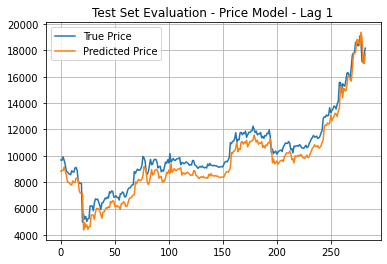

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_model_1 = Sequential()

price_model_1.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_1.shape[1], X_train_1.shape[2])))
price_model_1.add(Dropout(.2))
price_model_1.add(LSTM(units = 100))
price_model_1.add(Dropout(0.2))
price_model_1.add(Dense(units = 1))
price_model_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_history_1 = price_model_1.fit(X_train_1, y_train_1, epochs = 50, batch_size = 1485, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_model_1 = price_model_1.predict(X_train_1)
preds_test_price_model_1 = price_model_1.predict(X_test_1)

# Unscale 
preds_train_orig_price_model_1 = sc_price.inverse_transform(preds_train_price_model_1)
preds_test_orig_price_model_1 = sc_price.inverse_transform(preds_test_price_model_1)
y_train_orig_price_model_1 = sc_price.inverse_transform(y_train_1.reshape(-1,1))
y_test_orig_price_model_1 = sc_price.inverse_transform(y_test_1.reshape(-1,1))

# Model Evaluation
price_model_1_loss = price_model_1.evaluate(X_test_1, y_test_1)
print("Price Model 1 Overall Loss: {}".format(price_model_1_loss))

# Plot
plt.plot(y_test_orig_price_model_1, label="True Price")
plt.plot(preds_test_orig_price_model_1, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price Model - Lag 1")

### Price LSTM Lag 7 Model: $x_t = f(x_{t-7})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0023
Price Model 7 Overall Loss: 0.002300200518220663


Text(0.5, 1.0, 'Test Set Evaluation - Price Model - Lag 7')

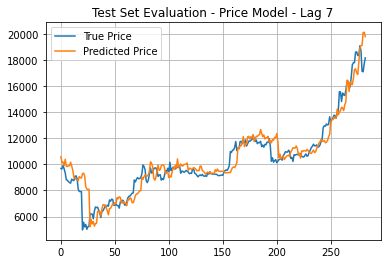

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_model_7 = Sequential()

price_model_7.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_7.shape[1], X_train_7.shape[2])))
price_model_7.add(Dropout(.2))
price_model_7.add(LSTM(units = 100))
price_model_7.add(Dropout(0.2))
price_model_7.add(Dense(units = 1))
price_model_7.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_history_7 = price_model_7.fit(X_train_7, y_train_7, epochs = 50, batch_size = 1485, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_model_7 = price_model_7.predict(X_train_7)
preds_test_price_model_7 = price_model_7.predict(X_test_7)

# Unscale 
preds_train_orig_price_model_7 = sc_price.inverse_transform(preds_train_price_model_7)
preds_test_orig_price_model_7 = sc_price.inverse_transform(preds_test_price_model_7)
y_train_orig_price_model_7 = sc_price.inverse_transform(y_train_7.reshape(-1,1))
y_test_orig_price_model_7 = sc_price.inverse_transform(y_test_7.reshape(-1,1))

# Model Evaluation
price_model_7_loss = price_model_7.evaluate(X_test_7, y_test_7)
print("Price Model 7 Overall Loss: {}".format(price_model_7_loss))

# Plot
plt.plot(y_test_orig_price_model_7, label="True Price")
plt.plot(preds_test_orig_price_model_7, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price Model - Lag 7")

### Price LSTM Lags 1-14 Model: $x_t = f(x_{t-1}, x_{t-2}, \dots, x_{t-14})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0069
Price Model All 14 Overall Loss: 0.006881377659738064


Text(0.5, 1.0, 'Test Set Evaluation - Price Model - Lags 1-14')

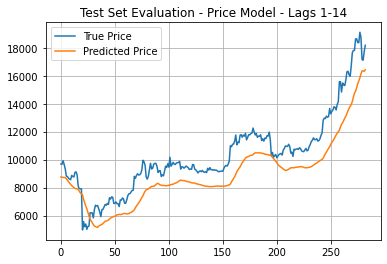

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_model_all_14 = Sequential()

price_model_all_14.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_all_14.shape[1], X_train_all_14.shape[2])))
price_model_all_14.add(Dropout(.2))
price_model_all_14.add(LSTM(units = 100))
price_model_all_14.add(Dropout(0.2))
price_model_all_14.add(Dense(units = 1))
price_model_all_14.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_history_all_14 = price_model_all_14.fit(X_train_all_14, y_train_all_14, epochs = 50, batch_size = 1485, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_model_all_14 = price_model_all_14.predict(X_train_all_14)
preds_test_price_model_all_14 = price_model_all_14.predict(X_test_all_14)

# Unscale 
preds_train_orig_price_model_all_14 = sc_price.inverse_transform(preds_train_price_model_all_14)
preds_test_orig_price_model_all_14 = sc_price.inverse_transform(preds_test_price_model_all_14)
y_train_orig_price_model_all_14 = sc_price.inverse_transform(y_train_all_14.reshape(-1,1))
y_test_orig_price_model_all_14 = sc_price.inverse_transform(y_test_all_14.reshape(-1,1))

# Model Evaluation
price_model_all_14_loss = price_model_all_14.evaluate(X_test_all_14, y_test_all_14)
print("Price Model All 14 Overall Loss: {}".format(price_model_all_14_loss))

# Plot
plt.plot(y_test_orig_price_model_all_14, label="True Price")
plt.plot(preds_test_orig_price_model_all_14, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price Model - Lags 1-14")

## Bitcoin Price Series GRU Models
Here we run the following models:
1. $x_t = f(x_{t-1})$, i.e., predicting tomorrow's price from today's price. 
2. $x_t = f(x_{t-7)}$, i.e., predicting next week's price from today's price. 
3. $x_t = f(x_{t-1}, x_{t-2}, \dots, x_{t-14})$, i.e., predicting tomorrow's price from the last 14 days of prices.

### 1. Price GRU Lag 1 Model: $x_t = f(x_{t-1})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0014
Price Model 1 Overall Loss: 0.0013991149608045816


Text(0.5, 1.0, 'Test Set Evaluation - Price GRU Model - Lag 1')

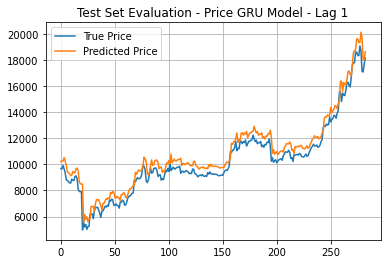

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_gru_model_1 = Sequential()

price_gru_model_1.add(GRU(units=300, return_sequences=True, input_shape=(X_train_1.shape[1], X_train_1.shape[2])))
price_gru_model_1.add(Dropout(.2))
price_gru_model_1.add(GRU(units = 100))
price_gru_model_1.add(Dropout(0.2))
price_gru_model_1.add(Dense(units = 1))
price_gru_model_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_gru_history_1 = price_gru_model_1.fit(X_train_1, y_train_1, epochs = 50, batch_size = 1485, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_gru_model_1 = price_gru_model_1.predict(X_train_1)
preds_test_price_gru_model_1 = price_gru_model_1.predict(X_test_1)

# Unscale 
preds_train_orig_price_gru_model_1 = sc_price.inverse_transform(preds_train_price_gru_model_1)
preds_test_orig_price_gru_model_1 = sc_price.inverse_transform(preds_test_price_gru_model_1)
y_train_orig_price_gru_model_1 = sc_price.inverse_transform(y_train_1.reshape(-1,1))
y_test_orig_price_gru_model_1 = sc_price.inverse_transform(y_test_1.reshape(-1,1))

# Model Evaluation
price_gru_model_1_loss = price_gru_model_1.evaluate(X_test_1, y_test_1)
print("Price Model 1 Overall Loss: {}".format(price_gru_model_1_loss))

# Plot
plt.plot(y_test_orig_price_gru_model_1, label="True Price")
plt.plot(preds_test_orig_price_gru_model_1, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price GRU Model - Lag 1")

### 2. Price GRU Lag 7 Model: $x_t = f(x_{t-7})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0075
Price GRU Model 7 Overall Loss: 0.00751045998185873


Text(0.5, 1.0, 'Test Set Evaluation - Price GRU Model - Lag 7')

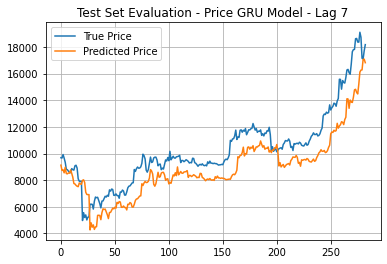

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_gru_model_7 = Sequential()

price_gru_model_7.add(GRU(units=300, return_sequences=True, input_shape=(X_train_7.shape[1], X_train_7.shape[2])))
price_gru_model_7.add(Dropout(.2))
price_gru_model_7.add(GRU(units = 100))
price_gru_model_7.add(Dropout(0.2))
price_gru_model_7.add(Dense(units = 1))
price_gru_model_7.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_gru_history_7 = price_gru_model_7.fit(X_train_7, y_train_7, epochs = 50, batch_size = 1485, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_gru_model_7 = price_gru_model_7.predict(X_train_7)
preds_test_price_gru_model_7 = price_gru_model_7.predict(X_test_7)

# Unscale 
preds_train_orig_price_gru_model_7 = sc_price.inverse_transform(preds_train_price_gru_model_7)
preds_test_orig_price_gru_model_7 = sc_price.inverse_transform(preds_test_price_gru_model_7)
y_train_orig_price_gru_model_7 = sc_price.inverse_transform(y_train_7.reshape(-1,1))
y_test_orig_price_gru_model_7 = sc_price.inverse_transform(y_test_7.reshape(-1,1))

# Model Evaluation
price_gru_model_7_loss = price_gru_model_7.evaluate(X_test_7, y_test_7)
print("Price GRU Model 7 Overall Loss: {}".format(price_gru_model_7_loss))

# Plot
plt.plot(y_test_orig_price_gru_model_7, label="True Price")
plt.plot(preds_test_orig_price_gru_model_7, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price GRU Model - Lag 7")

### 3. Price GRU Lags 1-14 Model: $x_t = f(x_{t-1},x_{t-2},\dots,x_{t-14})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0017
Price GRU Model All 14 Overall Loss: 0.0016771134687587619


Text(0.5, 1.0, 'Test Set Evaluation - Price GRU Model - Lags 1-14')

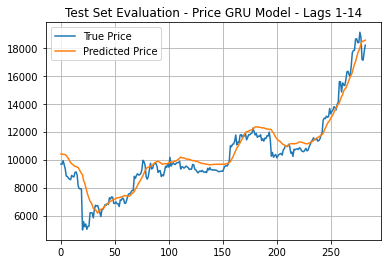

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_gru_model_all_14 = Sequential()

price_gru_model_all_14.add(GRU(units=300, return_sequences=True, input_shape=(X_train_all_14.shape[1], X_train_all_14.shape[2])))
price_gru_model_all_14.add(Dropout(.2))
price_gru_model_all_14.add(GRU(units = 100))
price_gru_model_all_14.add(Dropout(0.2))
price_gru_model_all_14.add(Dense(units = 1))
price_gru_model_all_14.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_gru_history_all_14 = price_gru_model_all_14.fit(X_train_all_14, y_train_all_14, epochs = 50, batch_size = 1485, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_gru_model_all_14 = price_gru_model_all_14.predict(X_train_all_14)
preds_test_price_gru_model_all_14 = price_gru_model_all_14.predict(X_test_all_14)

# Unscale 
preds_train_orig_price_gru_model_all_14 = sc_price.inverse_transform(preds_train_price_gru_model_all_14)
preds_test_orig_price_gru_model_all_14 = sc_price.inverse_transform(preds_test_price_gru_model_all_14)
y_train_orig_price_gru_model_all_14 = sc_price.inverse_transform(y_train_all_14.reshape(-1,1))
y_test_orig_price_gru_model_all_14 = sc_price.inverse_transform(y_test_all_14.reshape(-1,1))

# Model Evaluation
price_gru_model_all_14_loss = price_gru_model_all_14.evaluate(X_test_all_14, y_test_all_14)
print("Price GRU Model All 14 Overall Loss: {}".format(price_gru_model_all_14_loss))

# Plot
plt.plot(y_test_orig_price_gru_model_all_14, label="True Price")
plt.plot(preds_test_orig_price_gru_model_all_14, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price GRU Model - Lags 1-14")

## Bitcoin Price Series Decomposition LSTM Models

Here we decompose the price series into a rolling mean series and the induced rolling residual series. For these we will use a 30-day rolling window. 

Let $\mu_t$ be the rolling mean price at time $t$. 

Let $r_t$ be the rolling residual between the mean $\mu_t$ and the price $x_t$. 

We have the following model: 
$x_t = \mu_t + r_t$

Here, we fit separate LSTM models for the mean series and the residual series and then reconstruct the original for predictions. 

1. $\mu_t = f(\mu_{t-1})$, $r_t = f(r_{t-1})$
2. $\mu_t = f(\mu_{t-7})$, $r_t = f(r_{t-7})$
3. $\mu_t = f(\mu_{t-1}, \mu_{t-2}, \dots, \mu_{t-14})$, $r_t = f(r_{t-1}, r_{t-2}, \dots, r_{t-14})$

In [ ]:
# Create Rolling Means and Residuals
rolling = df['Adj Close'].rolling(window=30)
rolling_mean = rolling.mean()
rolling_resid = df['Adj Close'] - rolling_mean


In [ ]:
# Mean Series
train_mean = np.array(rolling_mean[29:1500]).reshape(-1,1) # First 30 days are NAN
test_mean = np.array(rolling_mean[1500:]).reshape(-1,1)

# Residual Series
train_resid = np.array(rolling_resid[29:1500]).reshape(-1,1) # First 30 days are NAN
test_resid = np.array(rolling_resid[1500:]).reshape(-1,1)

In [ ]:
## Feature Scaling
# Scaled Mean Series
sc_mean = MinMaxScaler(feature_range=(0,1))
train_mean_sc = sc_mean.fit_transform(train_mean)
test_mean_sc = sc_mean.transform(test_mean)

# Scaled Residual Series
sc_resid = MinMaxScaler(feature_range=(0,1))
train_resid_sc = sc_resid.fit_transform(train_resid)
test_resid_sc = sc_resid.transform(test_resid)

In [ ]:
# Create dataset with lag 1: use X_(t-1) to estimate X_(t)
X_train_mean_1, y_train_mean_1 = create_dataset(dataset=train_mean_sc, look_back=14, lag_list=[1])
X_test_mean_1, y_test_mean_1 = create_dataset(dataset=test_mean_sc, look_back=14, lag_list=[1])
print("Lag 1 Dataset")
print("X_train Mean Shape: {}".format(X_train_mean_1.shape))
print("y_train Mean Shape: {}".format(y_train_mean_1.shape))
print("X_test Mean Shape: {}".format(X_test_mean_1.shape))
print("y_test Mean Shape: {}\n".format(y_test_mean_1.shape))

# Create dataset with lag 7: use X_(t-7) to estimate X_(t)
X_train_mean_7, y_train_mean_7 = create_dataset(dataset=train_mean_sc, look_back=14, lag_list=[7])
X_test_mean_7, y_test_mean_7 = create_dataset(dataset=test_mean_sc, look_back=14, lag_list=[7])
print("Lag 7 Dataset")
print("X_train Mean Shape: {}".format(X_train_mean_7.shape))
print("y_train Mean Shape: {}".format(y_train_mean_7.shape))
print("X_test Mean Shape: {}".format(X_test_mean_7.shape))
print("y_test Mean Shape: {}\n".format(y_test_mean_7.shape))

# Create dataset with lag 14:use X_(t-14) to estimate X_(t)
X_train_mean_all_14, y_train_mean_all_14 = create_dataset(dataset=train_mean_sc, look_back=14, lag_list=None)
X_test_mean_all_14, y_test_mean_all_14 = create_dataset(dataset=test_mean_sc, look_back=14, lag_list=None)
print("Lag 14 Dataset")
print("X_train Mean Shape: {}".format(X_train_mean_all_14.shape))
print("y_train Mean Shape: {}".format(y_train_mean_all_14.shape))
print("X_test Mean Shape: {}".format(X_test_mean_all_14.shape))
print("y_test Mean Shape: {}\n".format(y_test_mean_all_14.shape))

Lag 1 Dataset
X_train Shape: (1456, 1, 1)
y_train Shape: (1456,)
X_test Shape: (283, 1, 1)
y_test Shape: (283,)

Lag 7 Dataset
X_train Shape: (1456, 1, 1)
y_train Shape: (1456,)
X_test Shape: (283, 1, 1)
y_test Shape: (283,)

Lag 14 Dataset
X_train Shape: (1456, 1, 14)
y_train Shape: (1456,)
X_test Shape: (283, 1, 14)
y_test Shape: (283,)



In [ ]:
# Create dataset with lag 1: use X_(t-1) to estimate X_(t)
X_train_resid_1, y_train_resid_1 = create_dataset(dataset=train_resid_sc, look_back=14, lag_list=[1])
X_test_resid_1, y_test_resid_1 = create_dataset(dataset=test_resid_sc, look_back=14, lag_list=[1])
print("Lag 1 Dataset")
print("X_train Residual Shape: {}".format(X_train_resid_1.shape))
print("y_train Residual Shape: {}".format(y_train_resid_1.shape))
print("X_test Residual Shape: {}".format(X_test_resid_1.shape))
print("y_test Residual Shape: {}\n".format(y_test_resid_1.shape))

# Create dataset with lag 7: use X_(t-7) to estimate X_(t)
X_train_resid_7, y_train_resid_7 = create_dataset(dataset=train_resid_sc, look_back=14, lag_list=[7])
X_test_resid_7, y_test_resid_7 = create_dataset(dataset=test_resid_sc, look_back=14, lag_list=[7])
print("Lag 7 Dataset")
print("X_train Residual Shape: {}".format(X_train_resid_7.shape))
print("y_train Residual Shape: {}".format(y_train_resid_7.shape))
print("X_test Residual Shape: {}".format(X_test_resid_7.shape))
print("y_test Residual Shape: {}\n".format(y_test_resid_7.shape))

# Create dataset with lag 14:use X_(t-14) to estimate X_(t)
X_train_resid_all_14, y_train_resid_all_14 = create_dataset(dataset=train_resid_sc, look_back=14, lag_list=None)
X_test_resid_all_14, y_test_resid_all_14 = create_dataset(dataset=test_resid_sc, look_back=14, lag_list=None)
print("Lag 14 Dataset")
print("X_train Residual Shape: {}".format(X_train_resid_all_14.shape))
print("y_train Residual Shape: {}".format(y_train_resid_all_14.shape))
print("X_test Residual Shape: {}".format(X_test_resid_all_14.shape))
print("y_test Residual Shape: {}\n".format(y_test_resid_all_14.shape))

Lag 1 Dataset
X_train Residual Shape: (1456, 1, 1)
y_train Residual Shape: (1456,)
X_test Residual Shape: (283, 1, 1)
y_test Residual Shape: (283,)

Lag 7 Dataset
X_train Residual Shape: (1456, 1, 1)
y_train Residual Shape: (1456,)
X_test Residual Shape: (283, 1, 1)
y_test Residual Shape: (283,)

Lag 14 Dataset
X_train Residual Shape: (1456, 1, 14)
y_train Residual Shape: (1456,)
X_test Residual Shape: (283, 1, 14)
y_test Residual Shape: (283,)



### Mean Lag 1 Model: $\mu_t = f(\mu_{t-1})$, Residual Lag 1 Model: $r_t = f(r_{t-1})$

9/9 [==============================] - 0s 5ms/step - loss: 9.8933e-04
Mean Model 1 Overall Loss: 0.0009893296519294381


Text(0.5, 1.0, 'Test Set Evaluation - Mean Model - Lag 1')

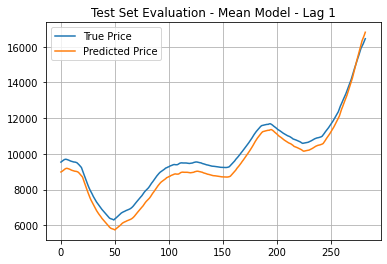

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

mean_model_1 = Sequential()

mean_model_1.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_mean_1.shape[1], X_train_mean_1.shape[2])))
mean_model_1.add(Dropout(.2))
mean_model_1.add(LSTM(units = 100))
mean_model_1.add(Dropout(0.2))
mean_model_1.add(Dense(units = 1))
mean_model_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
mean_history_1 = mean_model_1.fit(X_train_mean_1, y_train_mean_1, epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_mean_model_1 = mean_model_1.predict(X_train_mean_1)
preds_test_mean_model_1 = mean_model_1.predict(X_test_mean_1)

# Unscale 
preds_train_orig_mean_model_1 = sc_mean.inverse_transform(preds_train_mean_model_1)
preds_test_orig_mean_model_1 = sc_mean.inverse_transform(preds_test_mean_model_1)
y_train_orig_mean_model_1 = sc_mean.inverse_transform(y_train_mean_1.reshape(-1,1))
y_test_orig_mean_model_1 = sc_mean.inverse_transform(y_test_mean_1.reshape(-1,1))

# Model Evaluation
mean_model_1_loss = mean_model_1.evaluate(X_test_mean_1, y_test_mean_1)
print("Mean Model 1 Overall Loss: {}".format(mean_model_1_loss))

# Plot
plt.plot(y_test_orig_mean_model_1, label="True Price")
plt.plot(preds_test_orig_mean_model_1, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Mean Model - Lag 1")

9/9 [==============================] - 0s 4ms/step - loss: 0.0028
Residual Model Overall Loss: 0.0028486032970249653


Text(0.5, 1.0, 'Residual Test Set Evaluation - Residual Model - Lag 1')

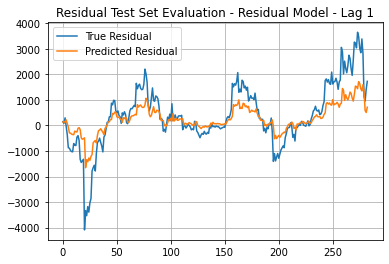

In [ ]:
resid_model_1 = Sequential()

resid_model_1.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_resid_1.shape[1], X_train_resid_1.shape[2])))
resid_model_1.add(Dropout(.2))
resid_model_1.add(LSTM(units = 200))
resid_model_1.add(Dropout(.2))
resid_model_1.add(Dense(units = 1))
resid_model_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
resid_history_1 = resid_model_1.fit(X_train_resid_1, y_train_resid_1, epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_resid_model_1 = resid_model_1.predict(X_train_resid_1)
preds_test_resid_model_1 = resid_model_1.predict(X_test_resid_1)

# Unscale 
preds_train_orig_resid_model_1 = sc_resid.inverse_transform(preds_train_resid_model_1)
preds_test_orig_resid_model_1 = sc_resid.inverse_transform(preds_test_resid_model_1)
y_train_orig_resid_model_1 = sc_resid.inverse_transform(y_train_resid_1.reshape(-1,1))
y_test_orig_resid_model_1 = sc_resid.inverse_transform(y_test_resid_1.reshape(-1,1))

# Model Evaluation
resid_model_1_loss = resid_model_1.evaluate(X_test_resid_1, y_test_resid_1)
print("Residual Model Overall Loss: {}".format(resid_model_1_loss))

# Plot 
plt.plot(y_test_orig_resid_model_1, label="True Residual")
plt.plot(preds_test_orig_resid_model_1, label="Predicted Residual")
plt.legend()
plt.grid()
plt.title("Residual Test Set Evaluation - Residual Model - Lag 1")

In [ ]:
## Reconstruct Predictions
# Training Predictions Reconstructed
preds_train_recon_1_sc = preds_train_mean_model_1 + preds_train_resid_model_1
preds_train_recon_1_orig = preds_train_orig_mean_model_1 + preds_train_orig_resid_model_1

#Testing Predictions Reconstructed
preds_test_recon_1_sc = preds_test_mean_model_1 + preds_test_resid_model_1
preds_test_recon_1_orig = preds_test_orig_mean_model_1 + preds_test_orig_resid_model_1

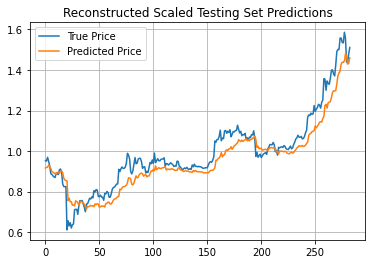

In [ ]:
# Plot Scaled Reconstruction
plt.plot((y_test_mean_1+y_test_resid_1), label="True Price")
plt.plot(preds_test_recon_1_sc, label="Predicted Price")
plt.title("Reconstructed Scaled Testing Set Predictions")
plt.grid()
plt.legend()

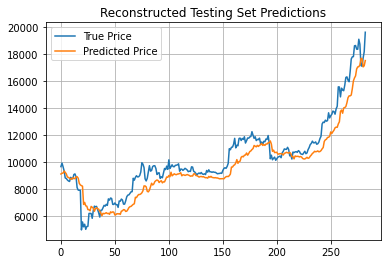

In [ ]:
# Plot Original Reconstruction
plt.plot((test_mean+test_resid)[15:], label="True Price")
plt.plot(preds_test_recon_1_orig, label="Predicted Price")
plt.title("Reconstructed Testing Set Predictions")
plt.grid()
plt.legend()

In [ ]:
def mse(data1,data2):
  data1_arr = np.array(data1).ravel()
  data2_arr = np.array(data2).ravel()
  mse = np.mean((data1_arr - data2_arr)**2)
  return mse

In [ ]:
mse_train_recon_1_orig = mse(data1=preds_train_recon_1_orig,data2=(train_mean+train_resid)[15:,:])
print("Train MSE of Price Lag-1 Model: ", mse_train_recon_1_orig)

mse_test_recon_1_orig = mse(data1=preds_test_recon_1_orig,data2=(test_mean+test_resid)[15:,:])
print("Test MSE of Price Lag-1 Model: ", mse_test_recon_1_orig)

mse_train_recon_1_sc = mse(data1=preds_train_recon_1_sc,data2=y_train_mean_1+y_train_resid_1)
print("Train MSE of Scaled Price Lag-1 Model: ", mse_train_recon_1_sc)

mse_test_recon_1_sc = mse(data1=preds_test_recon_1_sc,data2=y_test_mean_1+y_test_resid_1)
print("Test MSE of Scaled Price Lag-1 Model: ", mse_test_recon_1_sc)

Train MSE of Price Lag-1 Model:  759723.9111593947
Test MSE of Price Lag-1 Model:  1044532.4677469457
Train MSE of Scaled Price Lag-1 Model:  0.003137399293508108
Test MSE of Scaled Price Lag-1 Model:  0.004231244477934043


### Mean Lag 7 Model: $\mu_t = f(\mu_{t-7})$, Residual Lag 7 Model: $r_t = f(r_{t-7})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0034
Mean Model 7 Overall Loss: 0.00338179524987936


Text(0.5, 1.0, 'Test Set Evaluation - Mean Model - Lag 7')

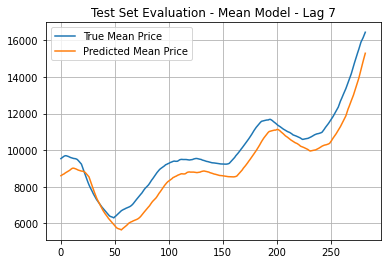

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

mean_model_7 = Sequential()

mean_model_7.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_mean_7.shape[1], X_train_mean_7.shape[2])))
mean_model_7.add(Dropout(.2))
mean_model_7.add(LSTM(units = 100))
mean_model_7.add(Dropout(0.2))
mean_model_7.add(Dense(units = 1))
mean_model_7.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
mean_history_7 = mean_model_7.fit(X_train_mean_7, y_train_mean_7, epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_mean_model_7 = mean_model_7.predict(X_train_mean_7)
preds_test_mean_model_7 = mean_model_7.predict(X_test_mean_7)

# Unscale 
preds_train_orig_mean_model_7 = sc_mean.inverse_transform(preds_train_mean_model_7)
preds_test_orig_mean_model_7 = sc_mean.inverse_transform(preds_test_mean_model_7)
y_train_orig_mean_model_7 = sc_mean.inverse_transform(y_train_mean_7.reshape(-1,1))
y_test_orig_mean_model_7 = sc_mean.inverse_transform(y_test_mean_7.reshape(-1,1))

# Evaluate
mean_model_7_loss = mean_model_7.evaluate(X_test_mean_7, y_test_mean_7)
print("Mean Model 7 Overall Loss: {}".format(mean_model_7_loss))

# Plot
plt.plot(y_test_orig_mean_model_7, label="True Mean Price")
plt.plot(preds_test_orig_mean_model_7, label="Predicted Mean Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Mean Model - Lag 7")

9/9 [==============================] - 0s 4ms/step - loss: 0.0046
Residual Model Overall Loss: 0.004594132304191589


Text(0.5, 1.0, 'Residual Test Set Evaluation - Residual Model - Lag 7')

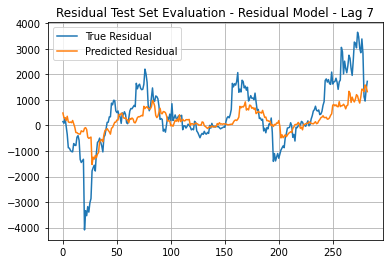

In [ ]:
resid_model_7 = Sequential()

resid_model_7.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_resid_7.shape[1], X_train_resid_7.shape[2])))
resid_model_7.add(Dropout(.2))
resid_model_7.add(LSTM(units = 100))
resid_model_7.add(Dense(units = 1))
resid_model_7.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
resid_history_7 = resid_model_7.fit(X_train_resid_7, y_train_resid_7, epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_resid_model_7 = resid_model_7.predict(X_train_resid_7)
preds_test_resid_model_7 = resid_model_7.predict(X_test_resid_7)

# Unscale 
preds_train_orig_resid_model_7 = sc_resid.inverse_transform(preds_train_resid_model_7)
preds_test_orig_resid_model_7 = sc_resid.inverse_transform(preds_test_resid_model_7)
y_train_orig_resid_model_7 = sc_resid.inverse_transform(y_train_resid_7.reshape(-1,1))
y_test_orig_resid_model_7 = sc_resid.inverse_transform(y_test_resid_7.reshape(-1,1))

# Evaluate
resid_model_7_loss = resid_model_7.evaluate(X_test_resid_7, y_test_resid_7)
print("Residual Model Overall Loss: {}".format(resid_model_7_loss))

# Plot
plt.plot(y_test_orig_resid_model_7, label="True Residual")
plt.plot(preds_test_orig_resid_model_7, label="Predicted Residual")
plt.legend()
plt.grid()
plt.title("Residual Test Set Evaluation - Residual Model - Lag 7")

In [ ]:
## Reconstruct Predictions
# Training Predictions Reconstructed
preds_train_recon_7_sc = preds_train_mean_model_7 + preds_train_resid_model_7
preds_train_recon_7_orig = preds_train_orig_mean_model_7 + preds_train_orig_resid_model_7

#Testing Predictions Reconstructed
preds_test_recon_7_sc = preds_test_mean_model_7 + preds_test_resid_model_7
preds_test_recon_7_orig = preds_test_orig_mean_model_7 + preds_test_orig_resid_model_7

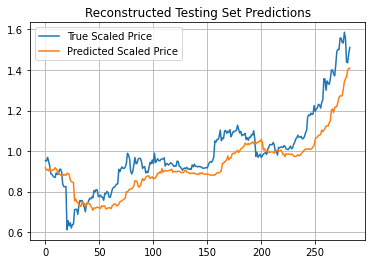

In [ ]:
# Plot Scaled Reconstruction
plt.plot(y_test_mean_7+y_test_resid_7, label="True Scaled Price")
plt.plot(preds_test_recon_7_sc, label="Predicted Scaled Price")
plt.title("Reconstructed Testing Set Predictions")
plt.grid()
plt.legend()

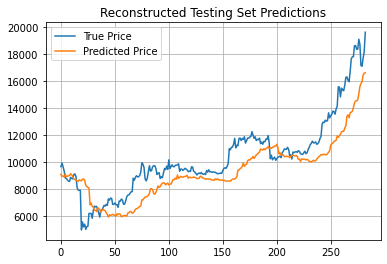

In [ ]:
# Plot Original Reconstruction
plt.plot(test_mean[15:]+test_resid[15:], label="True Price")
plt.plot(preds_test_recon_7_orig, label="Predicted Price")
plt.title("Reconstructed Testing Set Predictions")
plt.grid()
plt.legend()

In [ ]:
mse_train_recon_7_orig = mse(data1=preds_train_recon_7_orig,data2=(train_mean+train_resid)[15:,:])
print("Train MSE of Price Lag-7 Model: ", mse_train_recon_7_orig)

mse_test_recon_7_orig = mse(data1=preds_test_recon_7_orig,data2=(test_mean+test_resid)[15:,:])
print("Test MSE of Price Lag-7 Model: ", mse_test_recon_7_orig)

mse_train_recon_7_sc = mse(data1=preds_train_recon_7_sc,data2=y_train_mean_7+y_train_resid_7)
print("Train MSE of Scaled Price Lag-7 Model: ", mse_train_recon_7_sc)

mse_test_recon_7_sc = mse(data1=preds_test_recon_7_sc,data2=y_test_mean_7+y_test_resid_7)
print("Test MSE of Scaled Price Lag-7 Model: ", mse_test_recon_7_sc)

Train MSE of Price Lag-7 Model:  1605103.0081442185
Test MSE of Price Lag-7 Model:  2650253.2362116734
Train MSE of Scaled Price Lag-7 Model:  0.007174719553199138
Test MSE of Scaled Price Lag-7 Model:  0.011426244182353353


### Mean Lags 1-14 Model: $\mu_t = f(\mu_{t-1},\mu_{t-2},\dots,\mu_{t-14})$, Residual Lags 1-14 Model: $r_t = f(r_{t-1},r_{t-2},\dots,r_{t-14})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0014
Mean Model 1-14 Overall Loss: 0.0014037282671779394


Text(0.5, 1.0, 'Test Set Evaluation - Mean Model - Lags 1-14')

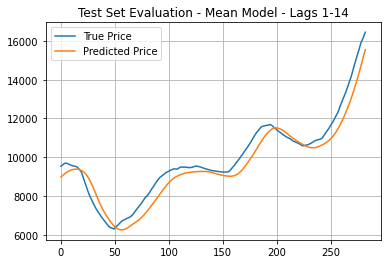

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

mean_model_all_14 = Sequential()

mean_model_all_14.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_mean_all_14.shape[1], X_train_mean_all_14.shape[2])))
mean_model_all_14.add(Dropout(.2))
mean_model_all_14.add(LSTM(units = 100))
mean_model_all_14.add(Dropout(0.2))
mean_model_all_14.add(Dense(units = 1))
mean_model_all_14.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
mean_history_all_14 = mean_model_all_14.fit(X_train_mean_all_14, y_train_mean_all_14, epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_mean_model_all_14 = mean_model_all_14.predict(X_train_mean_all_14)
preds_test_mean_model_all_14 = mean_model_all_14.predict(X_test_mean_all_14)

# Unscale 
preds_train_orig_mean_model_all_14 = sc_mean.inverse_transform(preds_train_mean_model_all_14)
preds_test_orig_mean_model_all_14 = sc_mean.inverse_transform(preds_test_mean_model_all_14)
y_train_orig_mean_model_all_14 = sc_mean.inverse_transform(y_train_mean_all_14.reshape(-1,1))
y_test_orig_mean_model_all_14 = sc_mean.inverse_transform(y_test_mean_all_14.reshape(-1,1))

# Evaluate
mean_model_all_14_loss = mean_model_all_14.evaluate(X_test_mean_all_14, y_test_mean_all_14)
print("Mean Model 1-14 Overall Loss: {}".format(mean_model_all_14_loss))

# Plot
plt.plot(y_test_orig_mean_model_all_14, label="True Price")
plt.plot(preds_test_orig_mean_model_all_14, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Mean Model - Lags 1-14")

9/9 [==============================] - 0s 3ms/step - loss: 0.0025
Residual Model Overall Loss: 0.002549991477280855


Text(0.5, 1.0, 'Test Set Evaluation - Residual Model - Lags 1-14')

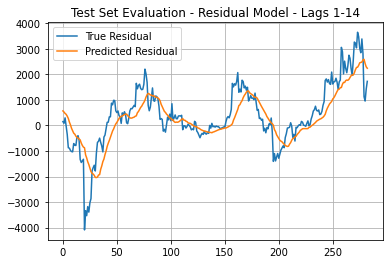

In [ ]:
resid_model_all_14 = Sequential()

resid_model_all_14.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_resid_all_14.shape[1], X_train_resid_all_14.shape[2])))
resid_model_all_14.add(Dropout(.2))
resid_model_all_14.add(LSTM(units = 100))
resid_model_all_14.add(Dropout(0.2))
resid_model_all_14.add(Dense(units = 1))
resid_model_all_14.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
resid_history_all_14 = resid_model_all_14.fit(X_train_resid_all_14, y_train_resid_all_14, epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_resid_model_all_14 = resid_model_all_14.predict(X_train_resid_all_14)
preds_test_resid_model_all_14 = resid_model_all_14.predict(X_test_resid_all_14)

# Unscale 
preds_train_orig_resid_model_all_14 = sc_resid.inverse_transform(preds_train_resid_model_all_14)
preds_test_orig_resid_model_all_14 = sc_resid.inverse_transform(preds_test_resid_model_all_14)
y_train_orig_resid_model_all_14 = sc_resid.inverse_transform(y_train_resid_all_14.reshape(-1,1))
y_test_orig_resid_model_all_14 = sc_resid.inverse_transform(y_test_resid_all_14.reshape(-1,1))

# Evaluate
resid_model_all_14_loss = resid_model_all_14.evaluate(X_test_resid_all_14, y_test_resid_all_14)
print("Residual Model Overall Loss: {}".format(resid_model_all_14_loss))

# Plot
plt.plot(y_test_orig_resid_model_all_14, label="True Residual")
plt.plot(preds_test_orig_resid_model_all_14, label="Predicted Residual")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Residual Model - Lags 1-14")

In [ ]:
## Reconstruct Predictions
# Training Predictions Reconstructed
preds_train_recon_all_14_sc = preds_train_mean_model_all_14 + preds_train_resid_model_all_14
preds_train_recon_all_14_orig = preds_train_orig_mean_model_all_14 + preds_train_orig_resid_model_all_14

#Testing Predictions Reconstructed
preds_test_recon_all_14_sc = preds_test_mean_model_all_14 + preds_test_resid_model_all_14
preds_test_recon_all_14_orig = preds_test_orig_mean_model_all_14 + preds_test_orig_resid_model_all_14

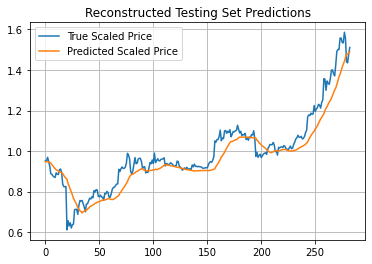

In [ ]:
# Plot Scaled Reconstruction
plt.plot(y_test_mean_all_14+y_test_resid_all_14, label="True Scaled Price")
plt.plot(preds_test_recon_all_14_sc, label="Predicted Scaled Price")
plt.title("Reconstructed Testing Set Predictions")
plt.grid()
plt.legend()

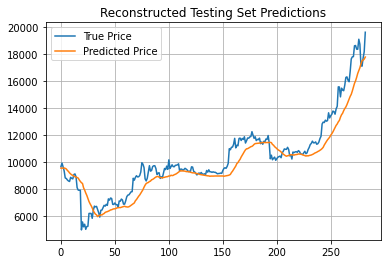

In [ ]:
# Plot Original Reconstruction
plt.plot(test_mean[15:]+test_resid[15:], label="True Price")
plt.plot(preds_test_recon_all_14_orig, label="Predicted Price")
plt.title("Reconstructed Testing Set Predictions")
plt.grid()
plt.legend()

In [ ]:
mse_train_recon_all_14_orig = mse(data1=preds_train_recon_all_14_orig,data2=(train_mean+train_resid)[15:,:])
print("Train MSE of Price Lags 1-14 Model: ", mse_train_recon_all_14_orig)

mse_test_recon_all_14_orig = mse(data1=preds_test_recon_all_14_orig,data2=(test_mean+test_resid)[15:,:])
print("Test MSE of Price Lags 1-14 Model: ", mse_test_recon_all_14_orig)

mse_train_recon_all_14_sc = mse(data1=preds_train_recon_all_14_sc,data2=y_train_mean_all_14+y_train_resid_all_14)
print("Train MSE of Scaled Price Lags 1-14 Model: ", mse_train_recon_all_14_sc)

mse_test_recon_all_14_sc = mse(data1=preds_test_recon_all_14_sc,data2=y_test_mean_all_14+y_test_resid_all_14)
print("Test MSE of Scaled Price Lags 1-14 Model: ", mse_test_recon_all_14_sc)

Train MSE of Price Lags 1-14 Model:  936958.8094189344
Test MSE of Price Lags 1-14 Model:  1110085.282812472
Train MSE of Scaled Price Lags 1-14 Model:  0.00393018367057187
Test MSE of Scaled Price Lags 1-14 Model:  0.004519950386159912


## Bitcoin Price Series LSTM Models with Extra Features

Here we use the rolling mean, rolling standard deviation, and trading volume as additional features to the price series models. 

Let $\mu_t = \frac{1}{30}\sum_{k=0}^{29}x_{t-k}$ be the 30-day rolling mean at time $t$.

Let $\sigma_t = \frac{1}{29}\sum_{k=0}^{29}(x_{t-k}-\mu_{t})^2$ be the 30-day rolling standard deviation at time $t$.

Let $v_t$ be the trading volume at time $t$. 

Here, we fit the following LSTM Models. 
1. $x_t = f(x_{t-1},\mu_{t-1},\sigma_{t-1},v_{t-1})$
2. $x_t = f(x_{t-7},\mu_{t-7},\sigma_{t-7},v_{t-7})$
3. $x_t = f(x_{t-1},\dots,x_{t-14},\mu_{t-1},\dots, \mu_{t-14},\sigma_{t-1},\dots,\sigma_{t-14},v_{t-1},\dots,v_{t-14})$

In [ ]:
# Create Rolling Standard Deviations
rolling_std = rolling.std()
train_std = np.array(rolling_std[29:1500]).reshape(-1,1) # First 30 days are NAN
test_std = np.array(rolling_std[1500:]).reshape(-1,1)

# Trading Volume
train_vol = np.array(df['Volume'][29:1500]).reshape(-1,1)
test_vol = np.array(df['Volume'][1500:]).reshape(-1,1)

In [ ]:
## Feature Scaling
# Scaled Standard Deviation Series
sc_std = MinMaxScaler(feature_range=(0,1))
train_std_sc = sc_std.fit_transform(train_std)
test_std_sc = sc_std.transform(test_std)

# Scaled Volume Series
sc_vol = MinMaxScaler(feature_range=(0,1))
train_vol_sc = sc_vol.fit_transform(train_vol)
test_vol_sc = sc_vol.transform(test_vol)

In [ ]:
# Create dataset with lag 1
X_train_std_1 = create_dataset(dataset=train_std_sc, look_back=14, lag_list=[1])[0]
X_test_std_1 = create_dataset(dataset=test_std_sc, look_back=14, lag_list=[1])[0]
print("Lag 1 Dataset")
print("X_train Standard Deviation Shape: {}".format(X_train_std_1.shape))
print("X_test Standard Deviation Shape: {}".format(X_test_std_1.shape))

# Create dataset with lag 7
X_train_std_7 = create_dataset(dataset=train_std_sc, look_back=14, lag_list=[7])[0]
X_test_std_7 = create_dataset(dataset=test_std_sc, look_back=14, lag_list=[7])[0]
print("Lag 7 Dataset")
print("X_train Standard Deviation Shape: {}".format(X_train_std_7.shape))
print("X_test Standard Deviation Shape: {}".format(X_test_std_7.shape))

# Create dataset with lag 14
X_train_std_all_14 = create_dataset(dataset=train_std_sc, look_back=14, lag_list=None)[0]
X_test_std_all_14 = create_dataset(dataset=test_std_sc, look_back=14, lag_list=None)[0]
print("Lag 14 Dataset")
print("X_train Standard Deviation Shape: {}".format(X_train_std_all_14.shape))
print("X_test Standard Deviation Shape: {}".format(X_test_std_all_14.shape))

Lag 1 Dataset
X_train Standard Deviation Shape: (1456, 1, 1)
X_test Standard Deviation Shape: (283, 1, 1)
Lag 7 Dataset
X_train Standard Deviation Shape: (1456, 1, 1)
X_test Standard Deviation Shape: (283, 1, 1)
Lag 14 Dataset
X_train Standard Deviation Shape: (1456, 1, 14)
X_test Standard Deviation Shape: (283, 1, 14)


In [ ]:
# Create dataset with lag 1
X_train_vol_1 = create_dataset(dataset=train_vol_sc, look_back=14, lag_list=[1])[0]
X_test_vol_1 = create_dataset(dataset=test_vol_sc, look_back=14, lag_list=[1])[0]
print("Lag 1 Dataset")
print("X_train Volume Shape: {}".format(X_train_vol_1.shape))
print("X_test Volume Shape: {}".format(X_test_vol_1.shape))

# Create dataset with lag 7
X_train_vol_7 = create_dataset(dataset=train_vol_sc, look_back=14, lag_list=[7])[0]
X_test_vol_7 = create_dataset(dataset=test_vol_sc, look_back=14, lag_list=[7])[0]
print("Lag 7 Dataset")
print("X_train Volume Shape: {}".format(X_train_vol_7.shape))
print("X_test Volume Shape: {}".format(X_test_vol_7.shape))

# Create dataset with lag 14
X_train_vol_all_14 = create_dataset(dataset=train_vol_sc, look_back=14, lag_list=None)[0]
X_test_vol_all_14 = create_dataset(dataset=test_vol_sc, look_back=14, lag_list=None)[0]
print("Lag 14 Dataset")
print("X_train Volume Shape: {}".format(X_train_vol_all_14.shape))
print("X_test Volume Shape: {}".format(X_test_vol_all_14.shape))

Lag 1 Dataset
X_train Volume Shape: (1456, 1, 1)
X_test Volume Shape: (283, 1, 1)
Lag 7 Dataset
X_train Volume Shape: (1456, 1, 1)
X_test Volume Shape: (283, 1, 1)
Lag 14 Dataset
X_train Volume Shape: (1456, 1, 14)
X_test Volume Shape: (283, 1, 14)


In [ ]:
# Combine Data for the 3 Models with Features

# Model 1
X_train_F_1 = np.hstack((X_train_1[29:].reshape(-1,1),
                         X_train_mean_1.reshape(-1,1),
                         X_train_std_1.reshape(-1,1),
                         X_train_vol_1.reshape(-1,1)))

X_test_F_1 = np.hstack((X_test_1.reshape(-1,1),
                        X_test_mean_1.reshape(-1,1),
                        X_test_std_1.reshape(-1,1),
                        X_test_vol_1.reshape(-1,1)))

X_train_F_1 = X_train_F_1.reshape(X_train_F_1.shape[0],1,X_train_F_1.shape[1])
X_test_F_1 = X_test_F_1.reshape(X_test_F_1.shape[0],1,X_test_F_1.shape[1])

print("Model 1 X_train Dimensions: {}".format(X_train_F_1.shape))
print("Model 1 X_test Dimensions: {}".format(X_test_F_1.shape))

# Model 2
X_train_F_7 = np.hstack((X_train_7[29:].reshape(-1,1),
                         X_train_mean_7.reshape(-1,1),
                         X_train_std_7.reshape(-1,1),
                         X_train_vol_7.reshape(-1,1)))

X_test_F_7 = np.hstack((X_test_7.reshape(-1,1),
                        X_test_mean_7.reshape(-1,1),
                        X_test_std_7.reshape(-1,1),
                        X_test_vol_7.reshape(-1,1)))

X_train_F_7 = X_train_F_7.reshape(X_train_F_7.shape[0],1,X_train_F_7.shape[1])
X_test_F_7 = X_test_F_7.reshape(X_test_F_7.shape[0],1,X_test_F_7.shape[1])

print("Model 2 X_train Dimensions: {}".format(X_train_F_7.shape))
print("Model 2 X_test Dimensions: {}".format(X_test_F_7.shape))

# Model 3
X_train_F_all_14 = np.hstack((X_train_all_14[29:].reshape(-1,14),
                              X_train_mean_all_14.reshape(-1,14),
                              X_train_std_all_14.reshape(-1,14),
                              X_train_vol_all_14.reshape(-1,14)))

X_test_F_all_14 = np.hstack((X_test_all_14.reshape(-1,14),
                              X_test_mean_all_14.reshape(-1,14),
                              X_test_std_all_14.reshape(-1,14),
                              X_test_vol_all_14.reshape(-1,14)))

X_train_F_all_14 = X_train_F_all_14.reshape(X_train_F_all_14.shape[0],1,X_train_F_all_14.shape[1])
X_test_F_all_14 = X_test_F_all_14.reshape(X_test_F_all_14.shape[0],1,X_test_F_all_14.shape[1])

print("Model 3 X_train Dimensions: {}".format(X_train_F_all_14.shape))
print("Model 3 X_test Dimensions: {}".format(X_test_F_all_14.shape))

Model 1 X_train Dimensions: (1456, 1, 4)
Model 1 X_test Dimensions: (283, 1, 4)
Model 2 X_train Dimensions: (1456, 1, 4)
Model 2 X_test Dimensions: (283, 1, 4)
Model 3 X_train Dimensions: (1456, 1, 56)
Model 3 X_test Dimensions: (283, 1, 56)


### Price LSTM Extra Features Lag 1 Model: $x_t = f(x_{t-1},\mu_{t-1},\sigma_{t-1},v_{t-1})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0113
Price Extra Features Model 1 Overall Loss: 0.011308413930237293


Text(0.5, 1.0, 'Test Set Evaluation - Price Extra Features Model - Lag 1')

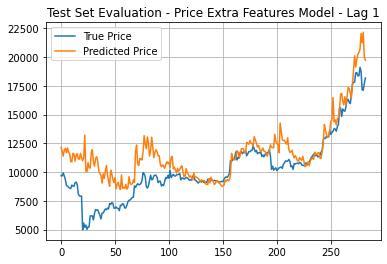

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_F_model_1 = Sequential()

price_F_model_1.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_F_1.shape[1], X_train_F_1.shape[2])))
price_F_model_1.add(Dropout(.2))
price_F_model_1.add(LSTM(units = 100))
price_F_model_1.add(Dropout(0.2))
price_F_model_1.add(Dense(units = 1))
price_F_model_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_F_history_1 = price_F_model_1.fit(X_train_F_1, y_train_1[29:], epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_F_model_1 = price_F_model_1.predict(X_train_F_1)
preds_test_price_F_model_1 = price_F_model_1.predict(X_test_F_1)

# Unscale 
preds_train_orig_price_F_model_1 = sc_price.inverse_transform(preds_train_price_F_model_1)
preds_test_orig_price_F_model_1 = sc_price.inverse_transform(preds_test_price_F_model_1)
y_train_orig_price_F_model_1 = sc_price.inverse_transform(y_train_1[29:].reshape(-1,1))
y_test_orig_price_F_model_1 = sc_price.inverse_transform(y_test_1.reshape(-1,1))

# Model Evaluation
price_F_model_1_loss = price_F_model_1.evaluate(X_test_F_1, y_test_1)
print("Price Extra Features Model 1 Overall Loss: {}".format(price_F_model_1_loss))

# Plot
plt.plot(y_test_orig_price_F_model_1, label="True Price")
plt.plot(preds_test_orig_price_F_model_1, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price Extra Features Model - Lag 1")

### Price LSTM Extra Features Lag 7 Model: $x_t = f(x_{t-7},\mu_{t-7},\sigma_{t-7},v_{t-7})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0108
Price Extra Features Model 7 Overall Loss: 0.01082470454275608


Text(0.5, 1.0, 'Test Set Evaluation - Price Extra Features Model - Lag 7')

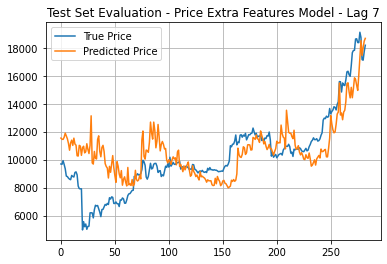

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_F_model_7 = Sequential()

price_F_model_7.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_F_7.shape[1], X_train_F_7.shape[2])))
price_F_model_7.add(Dropout(.2))
price_F_model_7.add(LSTM(units = 100))
price_F_model_7.add(Dropout(0.2))
price_F_model_7.add(Dense(units = 1))
price_F_model_7.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_F_history_7 = price_F_model_7.fit(X_train_F_7, y_train_7[29:], epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_F_model_7 = price_F_model_7.predict(X_train_F_7)
preds_test_price_F_model_7 = price_F_model_7.predict(X_test_F_7)

# Unscale 
preds_train_orig_price_F_model_7 = sc_price.inverse_transform(preds_train_price_F_model_7)
preds_test_orig_price_F_model_7 = sc_price.inverse_transform(preds_test_price_F_model_7)
y_train_orig_price_F_model_7 = sc_price.inverse_transform(y_train_7[29:].reshape(-1,1))
y_test_orig_price_F_model_7 = sc_price.inverse_transform(y_test_7.reshape(-1,1))

# Model Evaluation
price_F_model_7_loss = price_F_model_7.evaluate(X_test_F_7, y_test_7)
print("Price Extra Features Model 7 Overall Loss: {}".format(price_F_model_7_loss))

# Plot
plt.plot(y_test_orig_price_F_model_7, label="True Price")
plt.plot(preds_test_orig_price_F_model_7, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price Extra Features Model - Lag 7")

### Price LSTM Extra Features Lags 1-14 Model: $x_t = f(x_{t-1},\dots,x_{t-14},\mu_{t-1},\dots, \mu_{t-14},\sigma_{t-1},\dots,\sigma_{t-14},v_{t-1},\dots,v_{t-14})$

9/9 [==============================] - 0s 3ms/step - loss: 0.0101
Price Extra Features Model 1-14 Overall Loss: 0.010108022950589657


Text(0.5, 1.0, 'Test Set Evaluation - Price Extra Features Model - Lags 1-14')

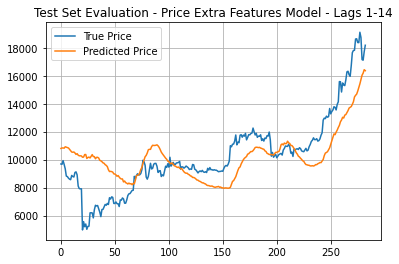

In [ ]:
# Build Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

price_F_model_all_14 = Sequential()

price_F_model_all_14.add(LSTM(units=300, return_sequences=True, input_shape=(X_train_F_all_14.shape[1], X_train_F_all_14.shape[2])))
price_F_model_all_14.add(Dropout(.2))
price_F_model_all_14.add(LSTM(units = 100))
price_F_model_all_14.add(Dropout(0.2))
price_F_model_all_14.add(Dense(units = 1))
price_F_model_all_14.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
price_F_history_all_14 = price_F_model_all_14.fit(X_train_F_all_14, y_train_all_14[29:], epochs = 50, batch_size = 1456, callbacks=[callback], verbose=0)

# Make predictions 
preds_train_price_F_model_all_14 = price_F_model_all_14.predict(X_train_F_all_14)
preds_test_price_F_model_all_14 = price_F_model_all_14.predict(X_test_F_all_14)

# Unscale 
preds_train_orig_price_F_model_all_14 = sc_price.inverse_transform(preds_train_price_F_model_all_14)
preds_test_orig_price_F_model_all_14 = sc_price.inverse_transform(preds_test_price_F_model_all_14)
y_train_orig_price_F_model_all_14 = sc_price.inverse_transform(y_train_all_14[29:].reshape(-1,1))
y_test_orig_price_F_model_all_14 = sc_price.inverse_transform(y_test_all_14.reshape(-1,1))

# Model Evaluation
price_F_model_all_14_loss = price_F_model_all_14.evaluate(X_test_F_all_14, y_test_all_14)
print("Price Extra Features Model 1-14 Overall Loss: {}".format(price_F_model_all_14_loss))

# Plot
plt.plot(y_test_orig_price_F_model_all_14, label="True Price")
plt.plot(preds_test_orig_price_F_model_all_14, label="Predicted Price")
plt.legend()
plt.grid()
plt.title("Test Set Evaluation - Price Extra Features Model - Lags 1-14")

## Collect Everything

In [ ]:
model_list = ["Price LSTM Model 1", "Price LSTM Model 7", "Price LSTM Model 1-14",
              "Price GRU Model 1", "Price GRU Model 7", "Price GRU Model 1-14",
              "Decomp LSTM Model 1", "Decomp LSTM Model 7", "Decomp LSTM Model 1-14",
              "Price LSTM F Model 1", "Price LSTM F Model 7", "Price LSTM F Model 1-14"]

test_error = [price_model_1_loss, price_model_7_loss, price_model_all_14_loss,
              price_gru_model_1_loss, price_gru_model_7_loss, price_gru_model_all_14_loss,
              mse_test_recon_1_sc, mse_test_recon_7_sc, mse_test_recon_all_14_sc,
              price_F_model_1_loss, price_F_model_7_loss, price_F_model_all_14_loss]

preds_test_orig = np.hstack((preds_test_orig_price_model_1.reshape(-1,1), 
                             preds_test_orig_price_model_7.reshape(-1,1), 
                             preds_test_orig_price_model_all_14.reshape(-1,1),
                             preds_test_orig_price_gru_model_1.reshape(-1,1), 
                             preds_test_orig_price_gru_model_7.reshape(-1,1), 
                             preds_test_orig_price_gru_model_all_14.reshape(-1,1),
                             preds_test_recon_1_orig.reshape(-1,1), 
                             preds_test_recon_7_orig.reshape(-1,1), 
                             preds_test_recon_all_14_orig.reshape(-1,1),
                             preds_test_orig_price_F_model_1.reshape(-1,1),
                             preds_test_orig_price_F_model_7.reshape(-1,1), 
                             preds_test_orig_price_F_model_all_14.reshape(-1,1)))


In [ ]:
test_error_df = pd.DataFrame(test_error, index=model_list)
test_error_df.columns = ["Test Error"]
test_error_df.to_csv("test_error.csv")

In [ ]:
preds_test_df = pd.DataFrame(preds_test_orig)
preds_test_df = pd.concat([pd.DataFrame(y_test_orig_price_F_model_1.reshape(-1,1)), preds_test_df], axis=1)
preds_test_df.columns = ["y_test"] + model_list
preds_test_df.to_csv("preds_test.csv")

In [ ]:
preds_test_df

,y_test,Price LSTM Model 1,Price LSTM Model 7,Price LSTM Model 1-14,Price GRU Model 1,Price GRU Model 7,Price GRU Model 1-14,Decomp LSTM Model 1,Decomp LSTM Model 7,Decomp LSTM Model 1-14,Price LSTM F Model 1,Price LSTM F Model 7,Price LSTM F Model 1-14
0,9686.441406,8830.908203,10576.643555,8760.526367,10213.725586,9127.645508,10399.780273,9116.612305,9089.199219,9550.268555,12139.270508,11538.257812,10798.253906
1,9663.181641,8909.786133,10129.894531,8739.208008,10293.128906,8735.563477,10409.367188,9171.519531,8940.785156,9555.708984,11839.429688,11452.932617,10828.502930
2,9924.515625,8886.240234,10177.281250,8723.451172,10269.436523,8777.253906,10368.516602,9187.379883,8979.973633,9549.669922,11388.259766,11445.322266,10833.590820
3,9650.174805,9151.456055,9920.607422,8721.953125,10535.839844,8551.135742,10370.192383,9332.486328,8896.304688,9560.660156,11907.944336,11598.913086,10816.118164
4,9341.705078,8873.079102,10396.380859,8704.273438,10256.187500,8969.697266,10346.691406,9239.124023,9109.922852,9534.064453,12054.863281,11892.483398,10917.220703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,18732.121094,19384.851562,19120.021484,16129.405273,20161.617188,16267.411133,18267.218750,17696.050781,15810.865234,17282.708984,22057.533203,18514.593750,15738.829102
279,17150.623047,18932.562500,19135.943359,16341.714844,19758.867188,16280.173828,18453.271484,17673.201172,15963.451172,17516.998047,21250.113281,17447.554688,16034.004883
280,17108.402344,17057.900391,20121.109375,16336.860352,18070.007812,17066.539062,18467.103516,17058.546875,16448.414062,17558.519531,22154.986328,17993.107422,16180.961914
281,17717.414063,17008.546875,20146.900391,16318.001953,18025.101562,17087.042969,18496.308594,17141.828125,16600.138672,17635.693359,19998.802734,18469.591797,16429.328125


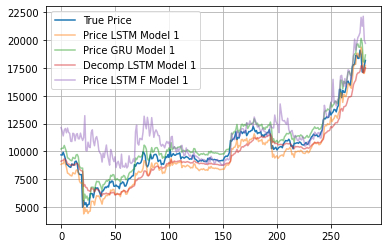

In [ ]:
plt.plot(preds_test_df['y_test'], label="True Price")
plt.plot(preds_test_df['Price LSTM Model 1'], label="Price LSTM Model 1", alpha=.5)
plt.plot(preds_test_df['Price GRU Model 1'], label="Price GRU Model 1", alpha=.5)
plt.plot(preds_test_df['Decomp LSTM Model 1'], label="Decomp LSTM Model 1", alpha=.5)
plt.plot(preds_test_df['Price LSTM F Model 1'], label="Price LSTM F Model 1", alpha=.5)
plt.grid()
plt.legend()

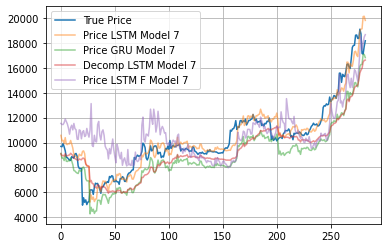

In [ ]:
plt.plot(preds_test_df['y_test'], label="True Price")
plt.plot(preds_test_df['Price LSTM Model 7'], label="Price LSTM Model 7", alpha=.5)
plt.plot(preds_test_df['Price GRU Model 7'], label="Price GRU Model 7", alpha=.5)
plt.plot(preds_test_df['Decomp LSTM Model 7'], label="Decomp LSTM Model 7", alpha=.5)
plt.plot(preds_test_df['Price LSTM F Model 7'], label="Price LSTM F Model 7", alpha=.5)
plt.grid()
plt.legend()

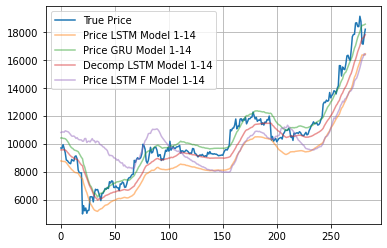

In [ ]:
plt.plot(preds_test_df['y_test'], label="True Price")
plt.plot(preds_test_df['Price LSTM Model 1-14'], label="Price LSTM Model 1-14", alpha=.5)
plt.plot(preds_test_df['Price GRU Model 1-14'], label="Price GRU Model 1-14", alpha=.5)
plt.plot(preds_test_df['Decomp LSTM Model 1-14'], label="Decomp LSTM Model 1-14", alpha=.5)
plt.plot(preds_test_df['Price LSTM F Model 1-14'], label="Price LSTM F Model 1-14", alpha=.5)
plt.grid()
plt.legend()

In [ ]:
test_error_df

,Test Error
Price LSTM Model 1,0.001841
Price LSTM Model 7,0.002300
Price LSTM Model 1-14,0.006881
Price GRU Model 1,0.001399
Price GRU Model 7,0.007510
Price GRU Model 1-14,0.001677
Decomp LSTM Model 1,0.004231
Decomp LSTM Model 7,0.011426
Decomp LSTM Model 1-14,0.004520
Price LSTM F Model 1,0.011308
